Данный ноутбук основан на основе [этой](https://habr.com/ru/company/X5Tech/blog/679842/) статьи.

## Метрики и точность их оценки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps

sns.set_style('darkgrid')
sns.set_palette('husl')

Рассмотрим пример вычисления оценки среднего и оценки для стандартного отклонения этой оценки среднего (ведь стандартное отклонение оценки среднего зависит только от истинной дисперсии). Допустим, что у нас есть информация о 1000 доставках. Распределение времени доставки в реальной жизни может быть произвольным. В примере будем генерировать время доставки из нормального распределения со средним 90 и стандартным отклонением 20. Сгенерируем выборку, оценим среднее и стандартное отклонение среднего.

In [2]:
time_to_delivery = sps.norm.rvs(loc=90, scale=20, size=1000)
print(f"Несмещенная оценка среднего равна {time_to_delivery.mean().round(4)}",
    f"Несмещенная оценка дисперсии выборочного среднего равна {(1 / np.sqrt(1000) * time_to_delivery.std(ddof=1)).round(4)}",
    sep='\n')

Несмещенная оценка среднего равна 90.6183
Несмещенная оценка дисперсии выборочного среднего равна 0.6449


Получилось, что в нашем примере 1000 наблюдений оказалось достаточно, чтобы стандартное отклонение оценки среднего было меньше минуты.

## Квантили

Мы легко можем оценить $n\%$ квантиль по данным, но как оценить стандартное отклонение **полученной оценки** (в примере выше мы, конечно, смогли явно вывести формулу, но в общем случае это сделать нельзя!)? Простой универсальной теоретической формулы для оценки стандартного отклонения квантиля нет.

Было бы хорошо, если у нас было 100 параллельных вселенных. Мы бы в каждой вселенной собрали данные, посчитали 100 квантилей и оценили стандартное отклонения по полученным значениям. Но у нас нет 100 параллельных вселенных.

Что же делать? На помощь к этому приходит бутстреп:)

## Бутстреп

Бутстреп (bootstrap) - это метод для оценки стандартных отклонений и нахождения доверительных интервалов статистических функционалов.

Разберёмся, как работает бутстреп. Напомним, что мы хотим оценить стандартное отклонение произвольной статистики. В статье мы будет оценивать стандартное отклонение оценки 90% квантиля. Т.е мы хотим понять, как далеко может быть разбросана наша выборочная квантиль порядка 0.9.

Если бы мы могли получать данные из исходного распределения, то могли бы сгенерировать из этого распределения 100 выборок, посчитать по ним 100 квантилей и оценить стандартное отклонение. Истинного распределения мы не знаем, но можем его оценить по имеющимся данным.

В качестве оценки функции распределения будем использовать эмпирическую функцию распределения (ЭФР). ЭФР является несмещённой оценкой для истинной ФР и сходится к ней при увеличении размера выборки (Теорема Гливенко-Кантелли).

Посмотрим как визуально выглядит ЭФР для данных разного размера из стандартного нормального распределения:

In [3]:
normal_sample_1 = sps.norm.rvs(size=50)
normal_sample_2 = sps.norm.rvs(size=500)
normal = sps.norm.cdf(loc=0, scale=1, x=np.linspace(start=-3, stop=3, num=1000))

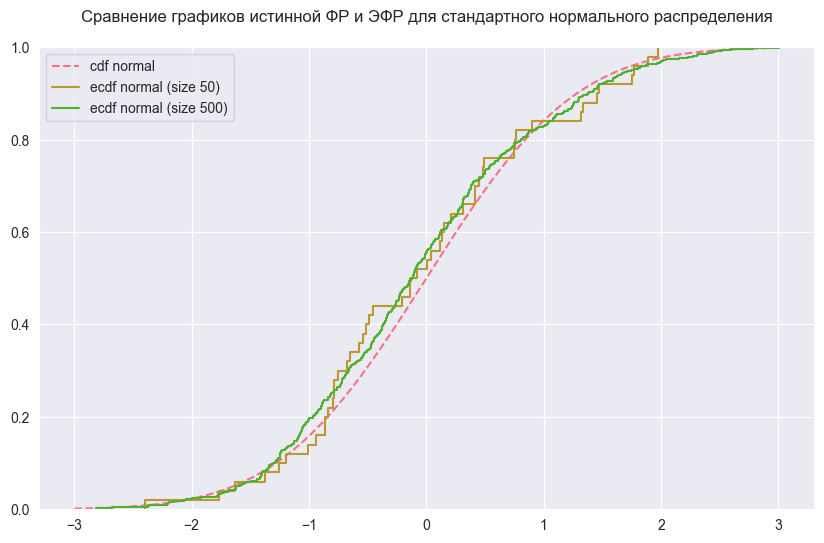

In [4]:
plt.figure(figsize=(10, 6))

ax_1 = plt.plot(np.linspace(start=-3, stop=3, num=1000), normal, '--', label='cdf normal')
ax_2 = sns.ecdfplot(normal_sample_1, label='ecdf normal (size 50)')
ax_3 = sns.ecdfplot(normal_sample_2, label='ecdf normal (size 500)')

plt.legend()
plt.title('Сравнение графиков истинной ФР и ЭФР для стандартного нормального распределения\n', fontsize=12);
plt.ylabel('');

На графике видно, что при увеличении размера выборки ЭФР лучше приближает истинную функцию распределения. Если увеличить размер выборки до нескольких тысяч, то ЭФР визуально будет сложно отличить от истинной функции распределения.

Так как нам известно, что ЭФР "хорошо" приближает истинную ФР, давайте генерировать данные из неё! Как это сделать?

Сгенерировать подвыборку размера n из ЭФР - это тоже самое, что выбрать случайно с возвращением n элементов из исходной выборки. Это можно сделать одной строчкой кода:

`np.random.choice(values, size=n, replace=True)`

А сгенерировать $M$ подвыборок размера $n$ можно, например, так:

`np.random.choice(values, size=(n, M), replace=True)`

Теперь мы можем оценить стандартное отклонение оценки квантиля. Для этого 1000 раз сгенерируем подвыборки из ЭФР, вычислим значение статистики в каждой подвыборке и оценим стандартное отклонение получившихся значений. Будем работать все с тем же временем доставки.

In [5]:
samples = np.random.choice(time_to_delivery, size=(1000, len(time_to_delivery)), replace=True)
bootstrap_stats = np.quantile(samples, q=0.9, axis=1)

print(f"Оценка квантиля порядка 0.9 равна {np.quantile(a=time_to_delivery, q=0.9).round(4)}",
    f"Оценка стандартного отклонения выборочной квантили порядка 0.9 равна {np.std(bootstrap_stats, ddof=1).round(4)}",
    sep='\n')

Оценка квантиля порядка 0.9 равна 116.7136
Оценка стандартного отклонения выборочной квантили порядка 0.9 равна 1.2929


Мы только что применили бутстреп для оценки стандартного отклонения 90% квантиля.

Обратим внимание на два момента:

Чтобы оценка стандартного отклонения была несмещённой, необходимо генерировать выборки такого же размера, как и размер исходной выборки;

Количество итераций бутстрепа рекомендуется брать в диапазоне от 1000 до 10000. Этого, как правило, хватает для получения достаточно точных результатов.

## Доверительные интервалы

 Мы научились оценивать стандартное отклонение оценки статистики. Зная стандартное отклонение, можно интуитивно понять насколько достоверны полученные результаты. Для получения более точных результатов можно построить доверительный интервал для интересующей нас статистики.

Опишем **три способа** построения доверительных интервалов с помощью бутстрапа для любой интересующей нас статистики.

### Способ 1. Нормальный доверительный интервал

1. С помощью статистики $\widehat{S} = \widehat{S}(X_1, ..., X_n)$, где X_1, ..., X_n - выборка, нужно оценить значение интересующей нас истинной характеристики распределения (например, с помощью выборочной медианы оценить медиану или с помощью выборочной квантили порядка n% оценить истинную квантиль порядка n%);
2. С помощью бутстрепа построить распределение статистики $\widehat{S}$ из пункта 1, а затем посчитать точечную несмещенную оценку стандартного отклонения для $\widehat{S}$;
3. По формуле вычислить доверительный интервал.

Формула имеет вид:
\begin{align*}
    [\widehat{S} - z_{1 - \alpha / 2} \cdot \widehat{\sqrt{\mathbb{D}(\widehat{S}}}), \widehat{S} + z_{1 - \alpha / 2} \cdot \widehat{\sqrt{\mathbb{D}(\widehat{S}}})],
\end{align*}
где $\widehat{S} = \widehat{S}(X_1, ..., X_n)$ - точечная оценка для интересующей нас истинной характеристики распределения, $z_{1 - \alpha / 2}$ - квантиль порядка $1 - \alpha / 2$ для стандартного нормального распределения, а $\widehat{\sqrt{\mathbb{D}(\widehat{S})}}$ - точечная несмещенная оценка для $\sqrt{\mathbb{D}(\widehat{S})}$, полученная с помощью бутстрап распределения.

In [6]:
def normal_bootstrap(data, alpha=0.05, n=3000, quantile=0.9):
    estimation = np.quantile(data, q=quantile)
    M = len(data)

    samples = np.random.choice(a=data, size=(n, M), replace=True)
    bootstrap_stats = np.quantile(samples, q=quantile, axis=1)
    
    z_alpha = sps.norm.ppf(q=1 - alpha / 2)
    left = estimation - z_alpha * np.std(a=bootstrap_stats, ddof=1)
    right = estimation + z_alpha * np.std(a=bootstrap_stats, ddof=1)
    width_ci = right - left

    print(f"Точечная оценка для истинной характеристики равна {estimation.round(4)}",
          f"Доверительный интервал для истинной характеристики равен {left.round(4), right.round(4)}",
          f"Ширина доверительного интервала равна {width_ci.round(4)}",
          sep='\n')

В качестве примера посмотрим это на наших данных `time_to_delivery`:

In [7]:
normal_bootstrap(time_to_delivery)

Точечная оценка для истинной характеристики равна 116.7136
Доверительный интервал для истинной характеристики равен (114.2217, 119.2056)
Ширина доверительного интервала равна 4.9838


### Способ 2. Перцентильный доверительный интервал

1. С помощью статистики $\widehat{S} = \widehat{S}(X_1, ..., X_n)$, где $X_1, ..., X_n$ - выборка, нужно оценить значение интересующей нас истинной характеристики распределения (например, с помощью выборочной медианы оценить медиану или с помощью выборочной квантили порядка n% оценить истинную квантиль порядка n%);
2. Построить распределение статистики $\widehat{S}$ из пункта 1 с помощью бутстрапа;
3. По формуле вычислить доверительный интервал.

Формула имеет вид:
\begin{align*}
    [\widehat{q_{\alpha / 2}}, \widehat{q_{1 - \alpha / 2}}],
\end{align*}
где $\widehat{q_{\alpha / 2}}$ и $\widehat{q_{1 - \alpha / 2}}$ - это выборочные квантили порядка $\alpha / 2$ и $1 - \alpha / 2$ соответственно, взятые из построенного бутстрап распределения.

In [8]:
def percentile_bootstrap(data, alpha=0.05, n=3000, quantile=0.9):
    estimation = np.quantile(data, q=quantile)
    M = len(data)

    samples = np.random.choice(a=data, size=(n, M), replace=True)
    bootstrap_stats = np.quantile(samples, q=quantile, axis=1)
    
    left = np.quantile(a=bootstrap_stats, q=alpha / 2)
    right = np.quantile(a=bootstrap_stats, q=1 - alpha / 2)
    width_ci = right - left

    print(f"Точечная оценка для истинной характеристики равна {estimation.round(4)}",
          f"Доверительный интервал для истинной характеристики равен {left.round(4), right.round(4)}",
          f"Ширина доверительного интервала равна {width_ci.round(4)}",
          sep='\n')

В качестве примера посмотрим это на наших данных `time_to_delivery`:

In [9]:
percentile_bootstrap(time_to_delivery)

Точечная оценка для истинной характеристики равна 116.7136
Доверительный интервал для истинной характеристики равен (114.0432, 118.8082)
Ширина доверительного интервала равна 4.765


### Способ 3. Центральный доверительный интервал

1. С помощью статистики $\widehat{S} = \widehat{S}(X_1, ..., X_n)$, где X_1, ..., X_n - выборка, нужно оценить значение интересующей нас истинной характеристики распределения (например, с помощью выборочной медианы оценить медиану или с помощью выборочной квантили порядка n% оценить истинную квантиль порядка n%);
2. Построить распределение статистики $\widehat{S}$ из пункта 1 с помощью бутстрапа;
3. По формуле вычислить доверительный интервал.

Формула имеет вид:
\begin{align*}
    [2 \cdot \widehat{S} - \widehat{q_{1 - \alpha / 2}}, 2 \cdot \widehat{S} - \widehat{q_{\alpha / 2}}],
\end{align*}
где $\widehat{q_{\alpha / 2}}$ и $\widehat{q_{1 - \alpha / 2}}$ - это выборочные квантили порядка $\alpha / 2$ и $1 - \alpha / 2$ соответственно, взятые из построенного бутстрап распределения, а $\widehat{S}$ - точечная оценка истинной характеристики распределения.

In [10]:
def central_bootstrap(data, alpha=0.05, n=3000, quantile=0.9):
    estimation = np.quantile(data, q=quantile)
    M = len(data)

    samples = np.random.choice(a=data, size=(n, M), replace=True)
    bootstrap_stats = np.quantile(samples, q=quantile, axis=1)
    
    left = 2 * estimation - np.quantile(a=bootstrap_stats, q=1 - alpha / 2)
    right = 2 * estimation - np.quantile(a=bootstrap_stats, q=alpha / 2)
    width_ci = right - left

    print(f"Точечная оценка для истинной характеристики равна {estimation.round(4)}",
          f"Доверительный интервал для истинной характеристики равен {left.round(4), right.round(4)}",
          f"Ширина доверительного интервала равна {width_ci.round(4)}",
          sep='\n')

В качестве примера посмотрим это на наших данных `time_to_delivery`:

In [11]:
central_bootstrap(time_to_delivery)

Точечная оценка для истинной характеристики равна 116.7136
Доверительный интервал для истинной характеристики равен (114.6112, 119.3549)
Ширина доверительного интервала равна 4.7436


## Бутстреп и А/Б тестирование

In [12]:
def central_bootstrap_ab(control, test, n=3000, alpha=0.05, quantile=0.9):
    M_1 = len(control)
    M_2 = len(test)

    # Шаг 1. Считаем разницу выборочных квантилей у теста и контроля.
    estimation = np.quantile(test, q=quantile) - np.quantile(control, q=quantile)

    # Шаг 2.1. Генерируем n псевдовыборок из контрольной (и тестовой) группы.
    bootstrap_values_c = np.random.choice(control, (n, M_1), replace=True)
    bootstrap_values_t = np.random.choice(test, (n, M_2), replace=True)

     # Шаг 2.2. Считаем n выборочных квантилей у n псевдовыборок из контрольной (тестовой) группы .
    bootstrap_metrics_c = np.quantile(bootstrap_values_c, 0.9, axis=1)
    bootstrap_metrics_t = np.quantile(bootstrap_values_t, 0.9, axis=1)

    # Шаг 3. Считаем разницу полученных метрик
    bootstrap_stats = bootstrap_metrics_t - bootstrap_metrics_c

    # Шаг 4. Строим доверительный интервал методом Центрального бутстрапа.
    left = 2 * estimation - np.quantile(a=bootstrap_stats, q=1 - alpha / 2)
    right = 2 * estimation - np.quantile(a=bootstrap_stats, q=alpha / 2)

    # Шаг 5. Смотрим ширину доверительного интервала и определяем наличие эффекта.
    width_ci = right - left
    effect = not [left <= 0 <= right][0]
    
    # Шаг 6. Вывод.
    print(f"Точечная оценка для истинной квантили равна {estimation.round(4)}",
          f"Доверительный интервал для разницы квантилей {left.round(4), right.round(4)}",
          f"Ширина доверительного интервала равна {width_ci.round(4)}",
          f"Ноль попадает в доверительный интервал: {effect}",
          sep='\n')

In [13]:
control = np.random.normal(90, 20, 1000)
test = np.random.normal(90, 15, 1000) # в тесте уменьшили дисперсию

central_bootstrap_ab(control, test, n=10000, quantile=0.9)

Точечная оценка для истинной квантили равна -6.2619
Доверительный интервал для разницы квантилей (-8.6639, -3.9132)
Ширина доверительного интервала равна 4.7507
Ноль попадает в доверительный интервал: True


Получилось, что 90% квантиль статистически значимо уменьшился.